In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [33]:
dataset = pd.read_csv('../secondMMRintData/fullFeature2MMRs.csv')

In [34]:
dataset.head()

,Unnamed: 0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,twoMMRstrengthfar,MEGNO,MEGNOstd,prelimStable,Stable
0,0,0,0.221502,0.017511,0.002935,0.104761,0.010371,0.300893,0.085965,0.011956,0.086689,0.000000,1.942393,0.032212,True,False
1,1,1,0.190647,0.073477,0.011405,0.033206,0.013957,0.403777,0.005775,0.000461,0.156924,0.000000,22.918673,7.372319,True,False
2,2,2,0.125660,0.034270,0.001506,0.334176,0.088234,0.720557,0.016427,0.008207,0.000000,0.000000,11.884854,3.404385,True,False
3,3,3,0.216684,0.008561,0.002451,0.012940,0.000000,0.235460,0.003955,0.000146,0.013127,0.005636,2.000019,0.001839,True,True
4,4,4,0.024455,NaN,NaN,NaN,NaN,0.034058,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [35]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [36]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 5.68 s, sys: 32 ms, total: 5.71 s
Wall time: 5.71 s


In [37]:
dataset

,Unnamed: 0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,twoMMRstrengthfar,MEGNO,MEGNOstd,prelimStable,Stable,hasnull
0,0,0,0.221502,0.017511,0.002935,0.104761,0.010371,0.300893,0.085965,0.011956,0.086689,0.000000,1.942393,0.032212,True,False,0
1,1,1,0.190647,0.073477,0.011405,0.033206,0.013957,0.403777,0.005775,0.000461,0.156924,0.000000,22.918673,7.372319,True,False,0
2,2,2,0.125660,0.034270,0.001506,0.334176,0.088234,0.720557,0.016427,0.008207,0.000000,0.000000,11.884854,3.404385,True,False,0
3,3,3,0.216684,0.008561,0.002451,0.012940,0.000000,0.235460,0.003955,0.000146,0.013127,0.005636,2.000019,0.001839,True,True,0
4,4,4,0.024455,NaN,NaN,NaN,NaN,0.034058,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133538,3538,138538,0.082222,0.049940,0.016289,0.608276,0.024447,0.664222,0.031330,0.003745,0.000000,0.000000,1.998822,0.003453,True,False,0
133539,3539,138539,0.251338,0.016063,0.002925,0.252494,0.000000,0.272822,0.002159,0.000486,0.016379,0.003788,2.487767,0.188649,True,False,0
133540,3540,138540,0.131799,0.027892,0.001453,0.659321,0.032653,0.366664,0.067070,0.020456,0.005420,0.000000,7.134970,1.931917,True,False,0
133541,3541,138541,0.209454,0.090838,0.010214,1.436775,0.037776,0.395073,0.102280,0.038515,0.039390,0.000000,2.117164,0.088393,True,False,0


In [38]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','twoMMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','twoMMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']
#what is being used to train
features = near + far + megno

pnear = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
pfar = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
pmegno = ['MEGNO', 'MEGNOstd']

pfeatures = pnear + pfar + pmegno

In [39]:
dataset

,Unnamed: 0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,twoMMRstrengthfar,MEGNO,MEGNOstd,prelimStable,Stable,hasnull
0,0,0,0.221502,0.017511,0.002935,0.104761,0.010371,0.300893,0.085965,0.011956,0.086689,0.000000,1.942393,0.032212,True,False,0
1,1,1,0.190647,0.073477,0.011405,0.033206,0.013957,0.403777,0.005775,0.000461,0.156924,0.000000,22.918673,7.372319,True,False,0
2,2,2,0.125660,0.034270,0.001506,0.334176,0.088234,0.720557,0.016427,0.008207,0.000000,0.000000,11.884854,3.404385,True,False,0
3,3,3,0.216684,0.008561,0.002451,0.012940,0.000000,0.235460,0.003955,0.000146,0.013127,0.005636,2.000019,0.001839,True,True,0
4,4,4,0.024455,NaN,NaN,NaN,NaN,0.034058,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133538,3538,138538,0.082222,0.049940,0.016289,0.608276,0.024447,0.664222,0.031330,0.003745,0.000000,0.000000,1.998822,0.003453,True,False,0
133539,3539,138539,0.251338,0.016063,0.002925,0.252494,0.000000,0.272822,0.002159,0.000486,0.016379,0.003788,2.487767,0.188649,True,False,0
133540,3540,138540,0.131799,0.027892,0.001453,0.659321,0.032653,0.366664,0.067070,0.020456,0.005420,0.000000,7.134970,1.931917,True,False,0
133541,3541,138541,0.209454,0.090838,0.010214,1.436775,0.037776,0.395073,0.102280,0.038515,0.039390,0.000000,2.117164,0.088393,True,False,0


add columns for tmax and hasnull manually

In [40]:
dataset['twoMMRstrengthfar'].isna().sum()


14589

Now we do the filtering manually. This is taking only systems with instability times > 1e4 AND no NaNs. Would adjust this for each case. 

We were worried that we were using filter=..., which was filtering out any rows that had any NaNs in them. We wanted to compare results when we don't include that filter, and only filtered for instability_time.

In [41]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [42]:
scrambled = filtData.sample(frac=1)

In [43]:
scrambled = scrambled.reset_index()

In [44]:
scrambled

,level_0,Unnamed: 0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,twoMMRstrengthfar,MEGNO,MEGNOstd,prelimStable,Stable,hasnull
0,78301,3301,78301,0.184141,0.022197,0.002049,0.109751,0.043483,0.353661,0.020042,0.002308,0.000000,0.000000,1.883893,0.026367,True,False,0
1,95997,997,95997,0.318549,0.121394,0.025849,0.146328,0.000000,0.577609,0.073608,0.013926,0.269465,0.000000,1.882552,0.057436,True,False,0
2,86740,1740,86740,0.090799,0.001438,0.000046,0.003898,0.000861,0.100105,0.004507,0.000022,0.034096,0.001518,1.956702,0.014914,True,True,0
3,92132,2132,92132,0.059227,0.019576,0.000378,0.223654,0.023422,0.256058,0.056493,0.006690,0.008386,0.000000,2.002262,0.001517,True,True,0
4,50492,492,50492,0.052546,0.032791,0.001014,0.039339,0.018457,0.420394,0.003617,0.000057,0.004348,0.000000,65.735768,17.761484,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118949,71080,1080,71080,0.160440,0.013269,0.000212,3.480997,0.002182,0.263095,0.062365,0.001421,0.004511,0.000000,2.005711,0.001046,True,True,0
118950,86166,1166,86166,0.256464,0.009918,0.003002,0.015495,0.000000,0.406093,0.008987,0.001169,1.143256,0.000000,1.991207,0.006128,True,True,0
118951,82982,2982,82982,0.062522,0.033539,0.000968,0.029682,0.008630,0.322447,0.005798,0.000032,0.030567,0.000000,5.190960,1.072469,True,False,0
118952,120891,891,120891,0.161547,0.073741,0.000247,2.590031,0.034243,0.253628,0.043423,0.001192,0.101200,0.000000,28.863584,6.544685,True,False,0


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [45]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]

# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [46]:
#features var covers all features
train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

2.386222111518343

In [47]:
# trainFStab= train.loc[train['Stable']==False]
# trainTStab= train.loc[train['Stable']==True]

In [48]:
# BT = pd.concat([trainTStab,trainFStab.sample(frac=1)]).sample(frac=1)

In [49]:
realTest = test.loc[test['prelimStable']==True]

There are more higher EMcrossnear values in the wrong guesses

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
train[features]

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,twoMMRstrengthfar,MEGNO,MEGNOstd
0,0.184141,0.022197,0.002049,0.109751,0.043483,0.353661,0.020042,0.002308,0.000000,0.000000,1.883893,0.026367
1,0.318549,0.121394,0.025849,0.146328,0.000000,0.577609,0.073608,0.013926,0.269465,0.000000,1.882552,0.057436
2,0.090799,0.001438,0.000046,0.003898,0.000861,0.100105,0.004507,0.000022,0.034096,0.001518,1.956702,0.014914
3,0.059227,0.019576,0.000378,0.223654,0.023422,0.256058,0.056493,0.006690,0.008386,0.000000,2.002262,0.001517
4,0.052546,0.032791,0.001014,0.039339,0.018457,0.420394,0.003617,0.000057,0.004348,0.000000,65.735768,17.761484
...,...,...,...,...,...,...,...,...,...,...,...,...
95158,0.027236,0.027822,0.000143,0.155129,0.030093,0.482722,0.000497,0.000005,0.000000,0.000000,1.996297,0.004217
95159,0.206202,0.116067,0.007189,0.239361,0.004263,0.227449,0.014800,0.000168,0.082466,0.029302,27.417551,7.013394
95160,0.120805,0.368278,0.017466,0.150279,0.021460,0.250606,0.026478,0.001356,0.437640,0.000000,81.679129,24.794470
95161,0.131245,0.053161,0.004163,1.128299,0.059066,0.747692,0.055164,0.015091,0.000000,0.000000,1.994283,0.004130


In [78]:
twoModel = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 30, 
                         subsample = 0.9,
                         min_child_weight = 5,
                         n_estimators = 300,
                         scale_pos_weight=2.4)

In [79]:
twoModel.fit(train[features], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [80]:
resPred = twoModel.predict_proba(realTest[features])[:,1]
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print( accuracy_score(twoModel.predict(realTest[features]), realTest["Stable"]))
#.5% increase in auc

0.9611035667675342
0.8997099743600521


In [67]:
oneModel = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 20, 
                         subsample = 0.9,
                         min_child_weight = 5,
                         n_estimators = 200,
                         scale_pos_weight=2.4)

In [68]:
oneModel.fit(train[pfeatures], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [70]:
resPred = oneModel.predict_proba(realTest[pfeatures])[:,1]
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(oneModel.predict(realTest[pfeatures]), realTest["Stable"]))

0.9556592278396914
0.8910092051616157


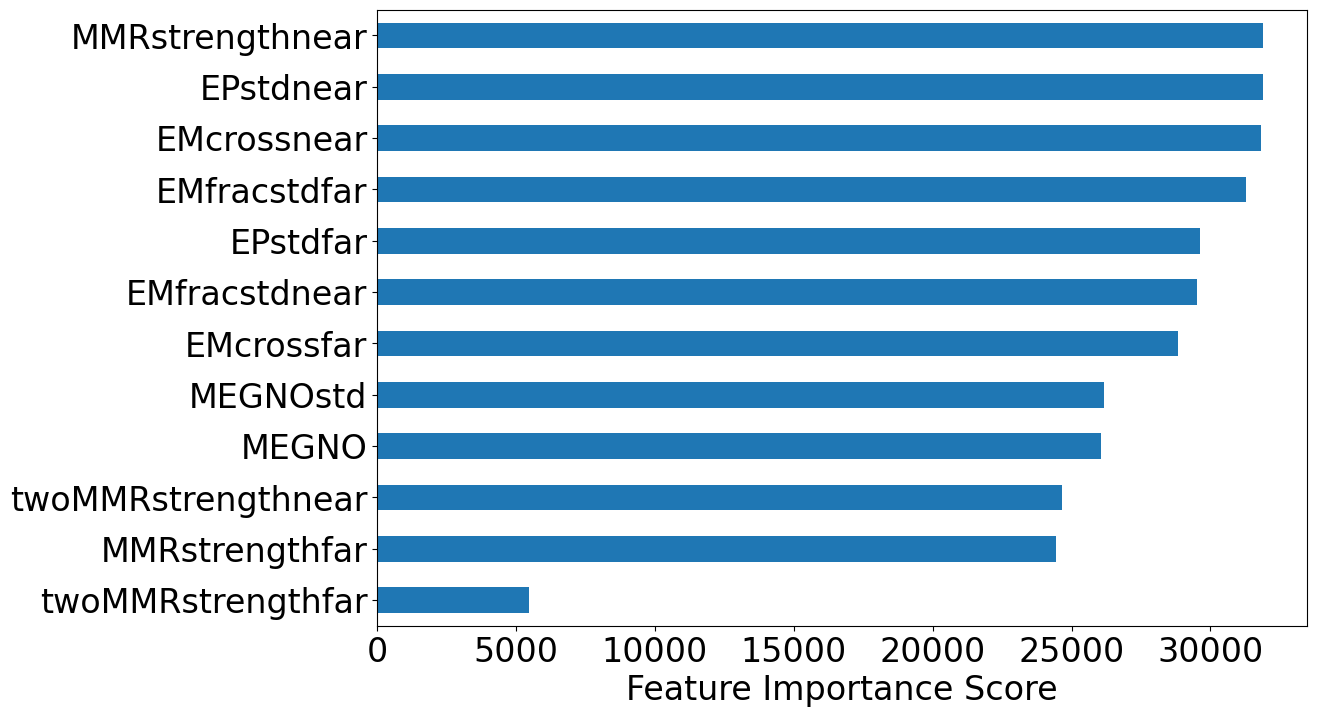

In [59]:
# feature importances
feat_imp = pd.Series(twoModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [60]:
twoModel.save_model('SPOCKalt.bin')